In [1]:

# Auto-reload external modules when their source changes
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
import src.train as train
import src.models as models
import utils.helpers as helpers
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt



# Path variables
BASE_PATH = "src/inputs/"
TRAIN_PATH = BASE_PATH + "train.csv"
TEST_PATH = BASE_PATH + "test.csv"
train_jpg = glob(BASE_PATH + "train/*.jpg")
test_jpg = glob(BASE_PATH + "test/*.jpg")



In [2]:
# to set the seeds for reproducibility
helpers.set_seeds()

Loading train and test csv files

In [3]:
train_df = pd.read_csv(BASE_PATH + "train.csv")
test_df =  pd.read_csv(BASE_PATH + "test.csv")


In [4]:
print("train shape:",train_df.shape)
print("test shape",test_df.shape)


train shape: (9912, 14)
test shape (8, 13)


In [5]:
train_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [6]:
test_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0


The train.csv and test.csv files contain metadata for photos in the training set and test set, respectively. Each pet photo is labeled with the value of 1 (Yes) or 0 (No) for each of the following features:

Focus - Pet stands out against uncluttered background, not too close / far.  
Eyes - Both eyes are facing front or near-front, with at least 1 eye / pupil decently clear.  
Face - Decently clear face, facing front or near-front.  
Near - Single pet taking up significant portion of photo (roughly over 50% of photo width or height).  
Action - Pet in the middle of an action (e.g., jumping).  
Accessory - Accompanying physical or digital accessory / prop (i.e. toy, digital sticker), excluding collar and leash.  
Group - More than 1 pet in the photo.  
Collage - Digitally-retouched photo (i.e. with digital photo frame, combination of multiple photos).  
Human - Human in the photo.  
Occlusion - Specific undesirable objects blocking part of the pet (i.e. human, cage or fence). Note that not all blocking objects are considered occlusion.  
Info - Custom-added text or labels (i.e. pet name, description).  
Blur - Noticeably out of focus or noisy, especially for the pet’s eyes and face. For Blur entries, “Eyes” column is always set to 0.  

In [7]:
print("Null Values: ",train_df.isnull().sum())
print("Duplicate Values: ",train_df.duplicated().sum())

Null Values:  Id               0
Subject Focus    0
Eyes             0
Face             0
Near             0
Action           0
Accessory        0
Group            0
Collage          0
Human            0
Occlusion        0
Info             0
Blur             0
Pawpularity      0
dtype: int64
Duplicate Values:  0


In [8]:
print("Null Values: ",test_df.isnull().sum())
print("Duplicate Values: ",test_df.duplicated().sum())

Null Values:  Id               0
Subject Focus    0
Eyes             0
Face             0
Near             0
Action           0
Accessory        0
Group            0
Collage          0
Human            0
Occlusion        0
Info             0
Blur             0
dtype: int64
Duplicate Values:  0


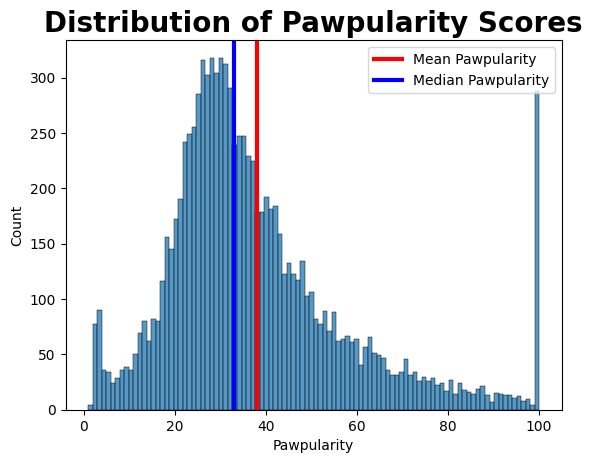

The mean Pawpularity score is 38.03904358353511
The median Pawpularity score is 33.0
The standard deviation of the Pawpularity score is 20.59199010577444
There are 100 unique values of Pawpularity score


In [9]:
#To check the distribution of Pawpularity Scores

helpers.plotDistribution(train_df)

print(f"The mean Pawpularity score is {train_df['Pawpularity'].mean()}")
print(f"The median Pawpularity score is {train_df['Pawpularity'].median()}")
print(f"The standard deviation of the Pawpularity score is {train_df['Pawpularity'].std()}")
print(f"There are {len(train_df['Pawpularity'].unique())} unique values of Pawpularity score")


> From the distribution graph above, we can see that pets with Pawpularity score 20 to 40 are more, Also there is a high peak at 100 score, but before that most of the pets have the score from around ~60 - ~90 .  

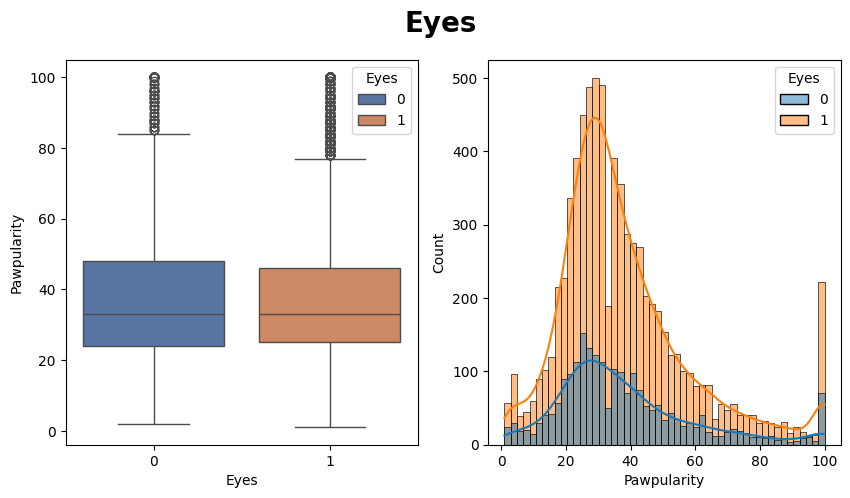

In [10]:
#showing one feature with the Pawpularity
helpers.plotDistributionAcrossEachFeature(["Eyes"],train_df)

> For the single feature like "Eye", both categories "0", "1" are similar as shown in the box plot, However we can see that those with high pawpularity are mostly the pets facing front or near-front, with at least 1 eye / pupil decently clear. 

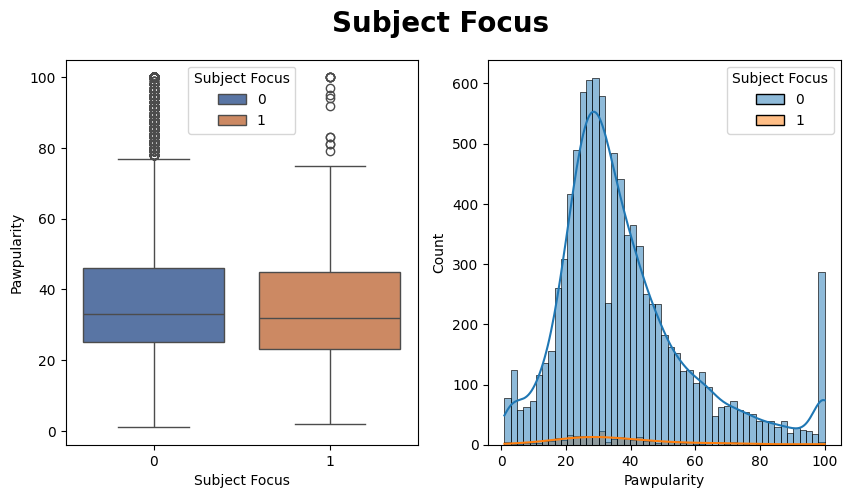

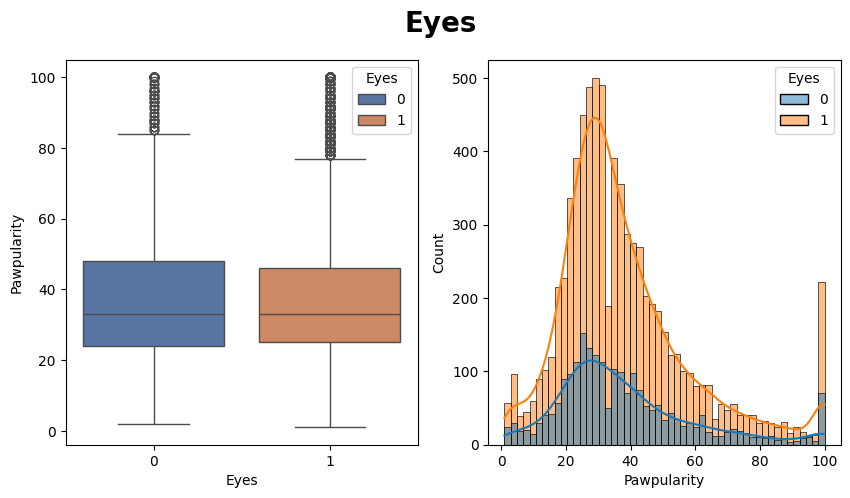

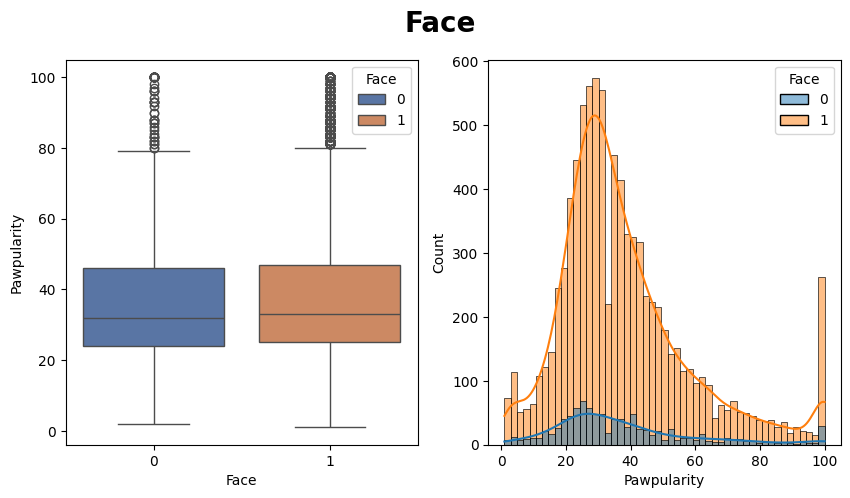

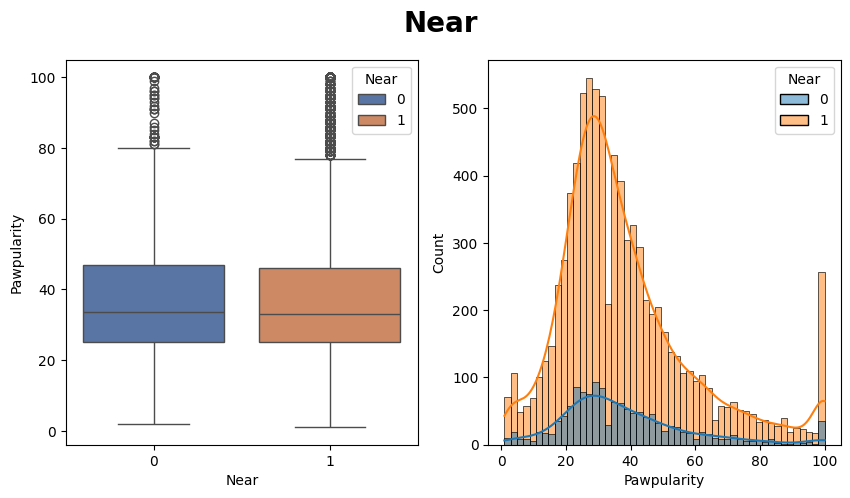

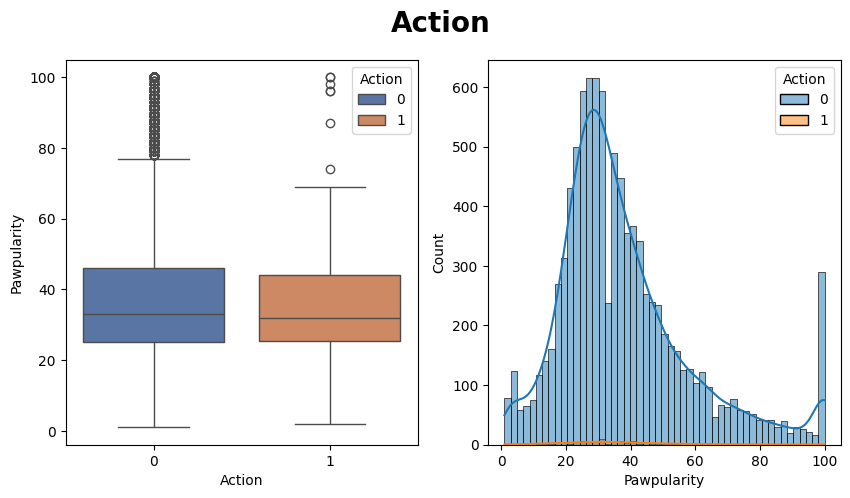

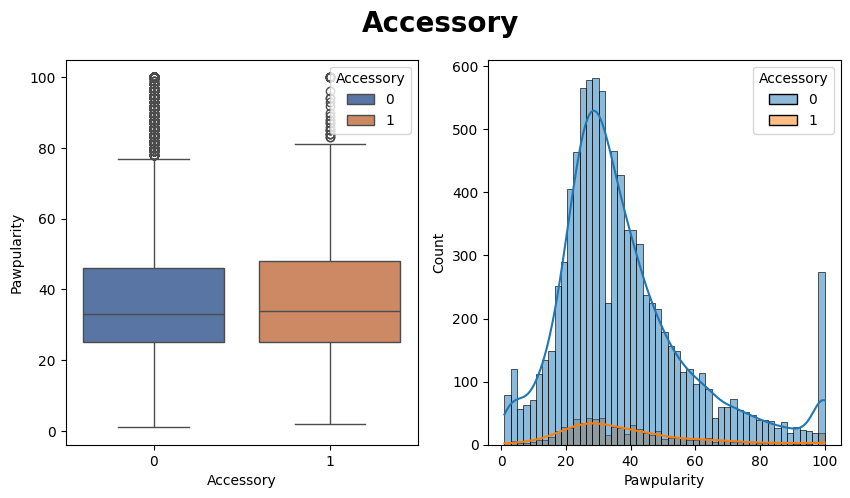

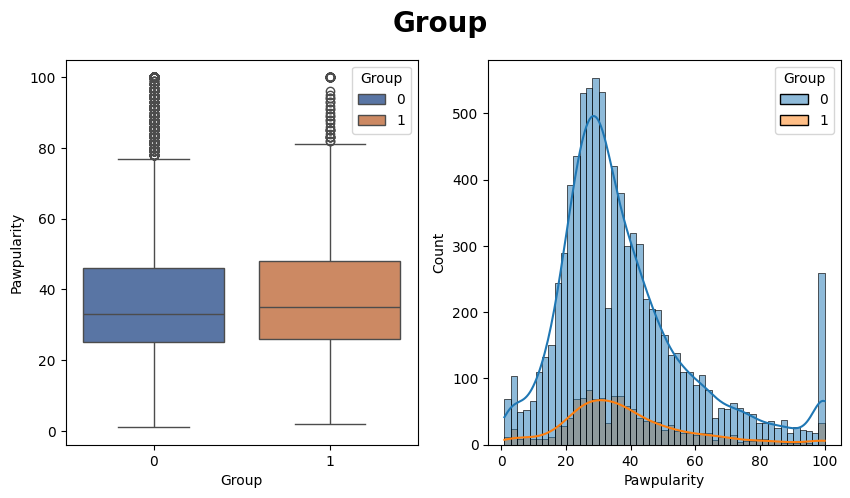

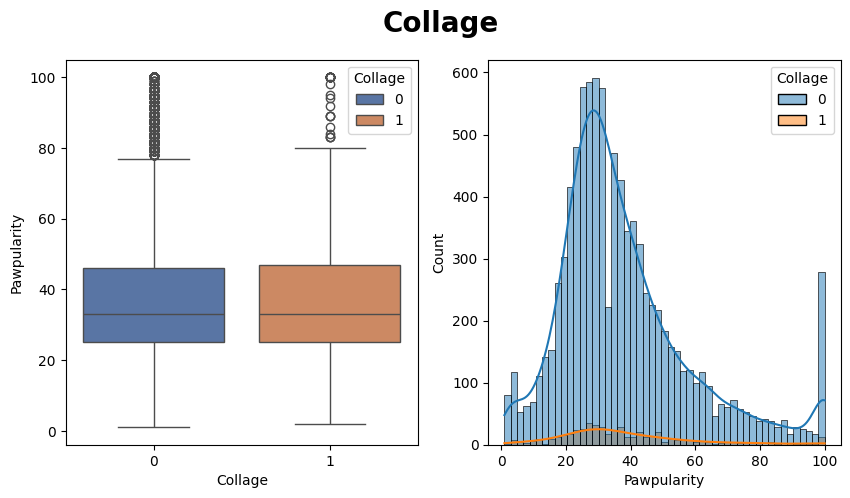

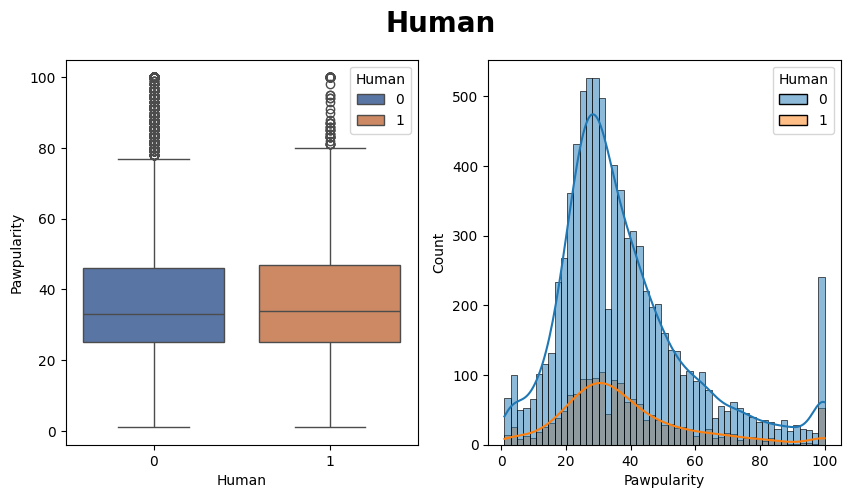

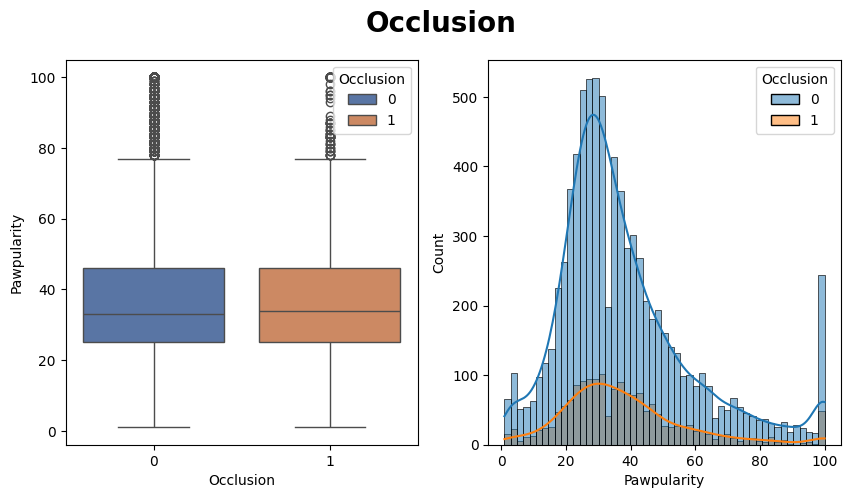

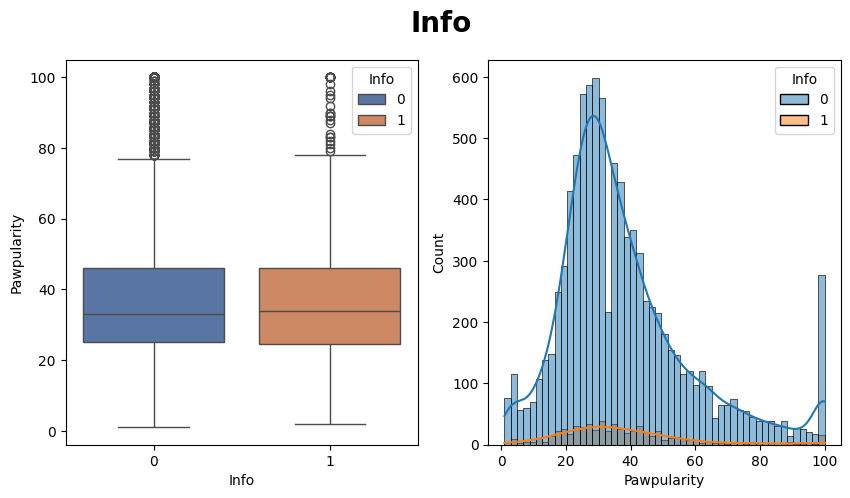

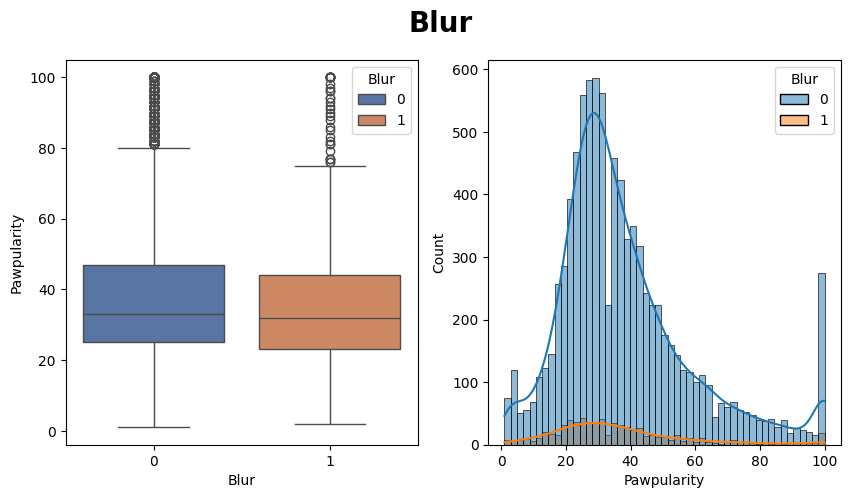

In [11]:
# Let's all features
feature_variables = train_df.columns.values.tolist()[1:-1] #to exclude id and Pawpularity
helpers.plotDistributionAcrossEachFeature(feature_variables,train_df)

> Looking at the above distribtions, we can see the usually the pets with less blur, no object or human inclusion, without frame and tools, near are labelled with high score, Now let's if there is any correlation between the feature and pawpularity

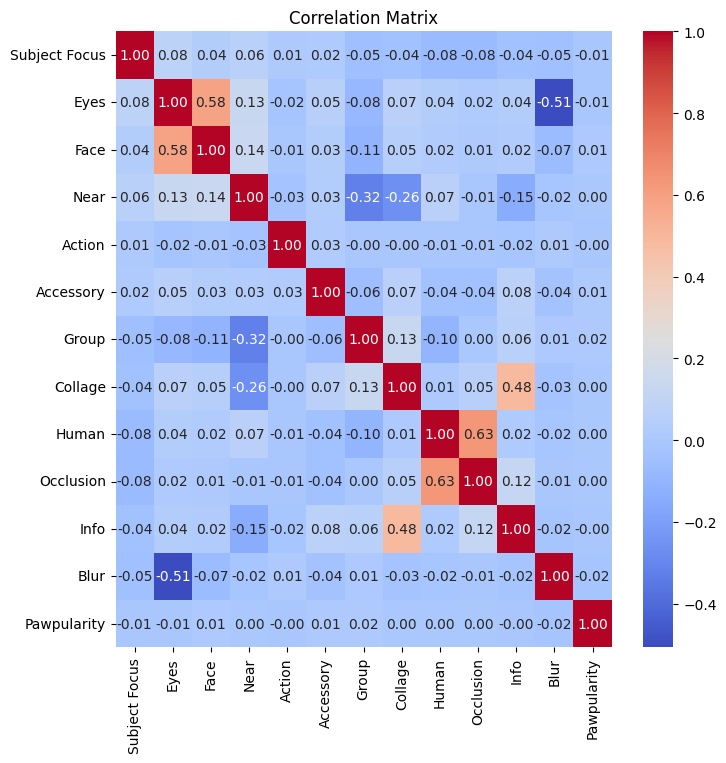

Subject Focus   -0.009853
Eyes            -0.006686
Face             0.008018
Near             0.001001
Action          -0.001373
Accessory        0.013287
Group            0.016469
Collage          0.001732
Human            0.003983
Occlusion        0.001979
Info            -0.004735
Blur            -0.023540
Name: Pawpularity, dtype: float64


In [12]:

helpers.plotCorrelationMatrix(train_df)


> Here we can see that there is not much significance correlation between the feature and pawpuarlity

### Now let's explore images

In [13]:
id_stem = Path(train_jpg[0]).stem
print('Original: ', train_jpg[0])
print('After: ', id_stem)


Original:  src/inputs/train\0007de18844b0dbbb5e1f607da0606e0.jpg
After:  0007de18844b0dbbb5e1f607da0606e0


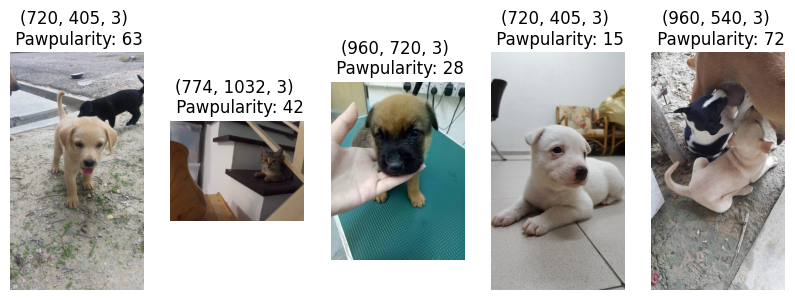

In [14]:
#let's see first 5 images
helpers.showPicture(5, train_jpg, train_df)

In [15]:
#Let's see the lowest and highest score images
print(train_df["Pawpularity"].max())
print(train_df["Pawpularity"].min())


100
1


In [16]:
train_df_max_id =  train_df.loc[train_df["Pawpularity"] == train_df["Pawpularity"].max(),"Id"].iloc[0]
train_df_min_id =  train_df.loc[train_df["Pawpularity"] == train_df["Pawpularity"].min(),"Id"].iloc[0]

In [17]:
filtered_jpg = [p for p in train_jpg if Path(p).stem in [train_df_max_id,train_df_min_id]]

##### let's check the high Pawpularity and low Pawpularity images

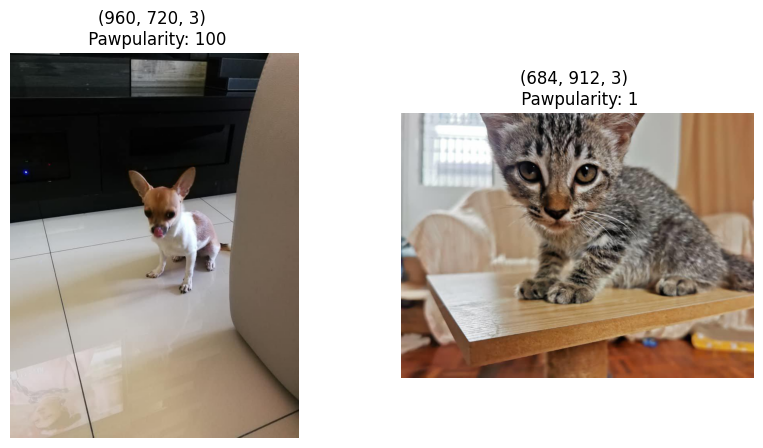

In [18]:
helpers.showPicture(2, filtered_jpg, train_df)

### 2.  Models

In [19]:
from fastai.vision.all import *


c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
set_seed(999, reproducible=True)


In [23]:
train_df['path'] = train_df['Id'].map(lambda x:str(BASE_PATH+'train/'+x)+'.jpg')
train_df = train_df.drop(columns=['Id'])
train_df = train_df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
train_df.head()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path
0,0,0,1,1,0,0,0,0,0,0,0,1,50,src/inputs/train/ebaaa8e384b3d2f0a56c7ff7675c154c.jpg
1,0,1,1,1,0,1,0,1,0,0,1,0,25,src/inputs/train/25e3bf4267c2dc3f579b779418221bb7.jpg
2,0,0,1,1,0,1,0,0,0,0,0,0,27,src/inputs/train/6548166fb3fda22b67881176397f0223.jpg
3,0,1,1,1,0,0,0,0,1,1,0,0,19,src/inputs/train/472c40116e1833555715e4774445ae5b.jpg
4,0,1,1,1,0,0,0,1,0,0,0,0,27,src/inputs/train/7b77e1a6d93667b575d57db83facd860.jpg


In [24]:
train_df['norm_score'] = train_df['Pawpularity']/100
train_df['norm_score']

0       0.50
1       0.25
2       0.27
3       0.19
4       0.27
        ... 
9907    0.26
9908    0.65
9909    0.38
9910    0.44
9911    0.62
Name: norm_score, Length: 9912, dtype: float64

In [25]:
train_df.head()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path,norm_score
0,0,0,1,1,0,0,0,0,0,0,0,1,50,src/inputs/train/ebaaa8e384b3d2f0a56c7ff7675c154c.jpg,0.50
1,0,1,1,1,0,1,0,1,0,0,1,0,25,src/inputs/train/25e3bf4267c2dc3f579b779418221bb7.jpg,0.25
2,0,0,1,1,0,1,0,0,0,0,0,0,27,src/inputs/train/6548166fb3fda22b67881176397f0223.jpg,0.27
3,0,1,1,1,0,0,0,0,1,1,0,0,19,src/inputs/train/472c40116e1833555715e4774445ae5b.jpg,0.19
4,0,1,1,1,0,0,0,1,0,0,0,0,27,src/inputs/train/7b77e1a6d93667b575d57db83facd860.jpg,0.27


In [29]:
im = Image.open(train_df['path'][1])
width, height = im.size
print(width,height)


960 960


In [30]:
dls = ImageDataLoaders.from_df(train_df, #pass in train DataFrame
                               valid_pct=0.2, #80-20 train-validation random split
                               seed=999, #seed
                               fn_col='path', #filename/path is in the second column of the DataFrame
                               label_col='norm_score', #label is in the first column of the DataFrame
                               y_block=RegressionBlock, #The type of target
                               bs=32, #pass in batch size
                               num_workers=8,
                               item_tfms=Resize(224), #pass in item_tfms
                               batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) #pass in batch_tfms

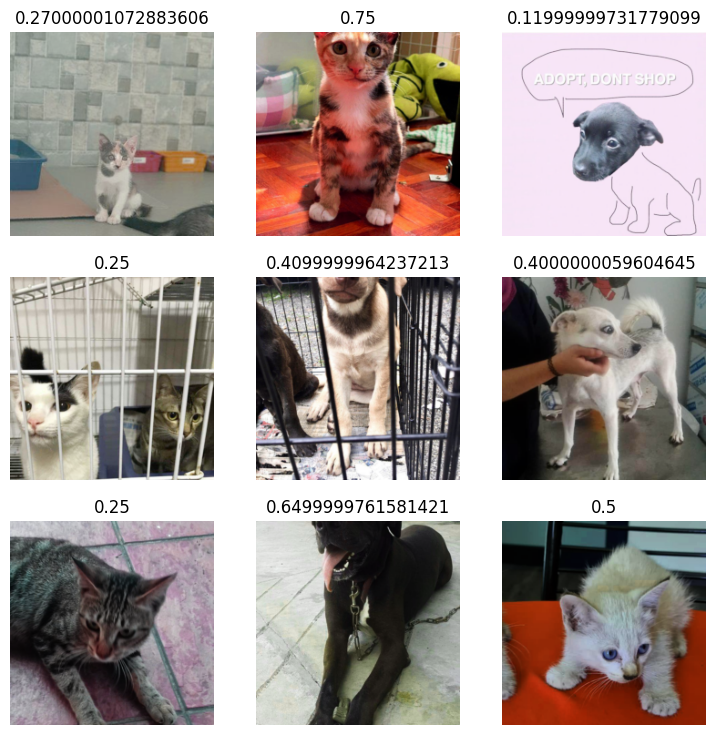

In [31]:
dls.show_batch()

In [33]:
from timm import create_model

model = create_model('swin_large_patch4_window7_224', pretrained=True, num_classes=dls.c)


In [34]:
def petfinder_rmse(input,target):
    return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))

In [35]:
learn = Learner(dls, model, loss_func=BCEWithLogitsLossFlat(), metrics=AccumMetric(petfinder_rmse)).to_fp16()

c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


SuggestedLRs(valley=0.00015022089064586908)

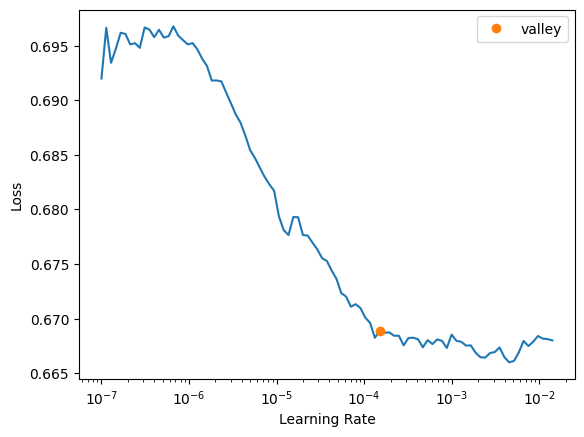

In [36]:
learn.lr_find(end_lr=3e-2)


In [37]:
learn.fit_one_cycle(10, 2e-5, cbs=[SaveModelCallback(), EarlyStoppingCallback(monitor='petfinder_rmse', comp=np.less, patience=3)])

c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.658550,0.651865,19.232073,05:49
1,0.647078,0.641928,17.959213,04:00
2,0.640793,0.638474,17.506639,03:56
3,0.633883,0.638370,17.455957,04:07
4,0.626927,0.640925,17.763134,04:07
5,0.622648,0.641472,17.788275,04:04
6,0.615775,0.644458,18.128826,04:11


Better model found at epoch 0 with valid_loss value: 0.6518650650978088.
Better model found at epoch 1 with valid_loss value: 0.6419282555580139.
Better model found at epoch 2 with valid_loss value: 0.6384738683700562.
Better model found at epoch 3 with valid_loss value: 0.6383699774742126.
No improvement since epoch 3: early stopping


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

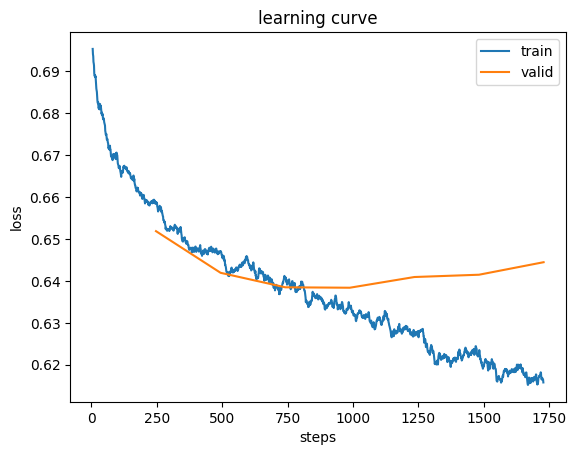

In [38]:
learn.recorder.plot_loss()

In [39]:
learn = learn.to_fp32()

In [40]:
learn.save('fine-tuned')

Path('models/fine-tuned.pth')

In [41]:
learn.export()


In [42]:
test_df = pd.read_csv(BASE_PATH+'test.csv')
test_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0


In [43]:
test_df['Pawpularity'] = [1]*len(test_df)
test_df['path'] = test_df['Id'].map(lambda x:str(BASE_PATH+'test/'+x)+'.jpg')
test_df = test_df.drop(columns=['Id'])
train_df['norm_score'] = train_df['Pawpularity']/100
test_dl = dls.test_dl(test_df)

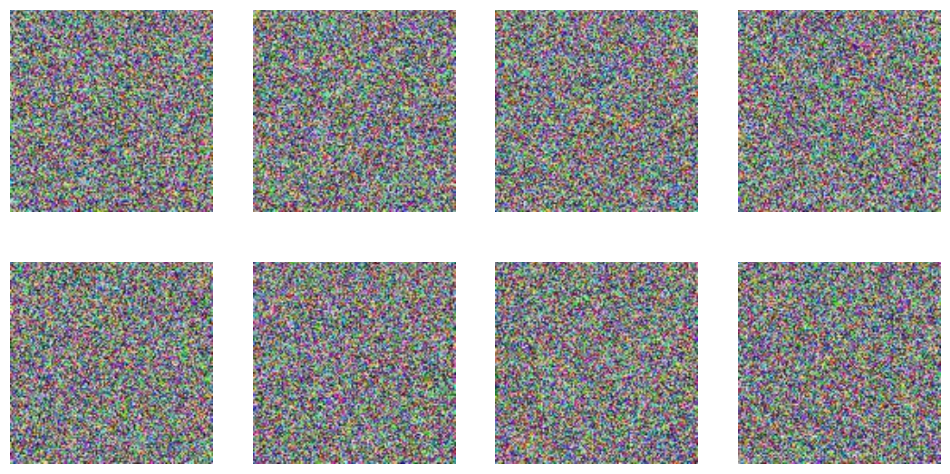

In [44]:
test_dl.show_batch()


In [45]:
preds, _ = learn.tta(dl=test_dl, n=5, beta=0)


In [46]:
preds

tensor([[0.4096],
        [0.4249],
        [0.4192],
        [0.4153],
        [0.4386],
        [0.4371],
        [0.4327],
        [0.4241]])

In [ ]:

preds = preds.flatten() * 100
test_labels = test_labels.flatten() * 100

# Calculate RMSE
rmse = np.sqrt(np.mean((preds - test_labels) ** 2))
print(f"Test RMSE: {rmse:.4f}")
